<ipython-input-4-11061c5e3923>:13: RuntimeWarning: invalid value encountered in divide
  transition_matrix = adjacency_matrix / row_sums


PageRank Scores: [0.05108789 0.05657572 0.08747202 0.06932948 0.06254111 0.06254111
 0.0721487  0.05508254 0.05207163 0.05207163 0.03732401 0.03385693
 0.03257737 0.03257737 0.02922526 0.01336257 0.0157688  0.0214305
 0.00666083 0.04440555 0.01158406 0.01158406 0.01650728 0.02069202
 0.02424905 0.02727253]
Sorted PageRank Scores:
Node 2: 0.0875
Node 6: 0.0721
Node 3: 0.0693
Node 4: 0.0625
Node 5: 0.0625
Node 1: 0.0566
Node 7: 0.0551
Node 8: 0.0521
Node 9: 0.0521
Node 0: 0.0511
Node 19: 0.0444
Node 10: 0.0373
Node 11: 0.0339
Node 12: 0.0326
Node 13: 0.0326
Node 14: 0.0292
Node 25: 0.0273
Node 24: 0.0242
Node 17: 0.0214
Node 23: 0.0207
Node 22: 0.0165
Node 16: 0.0158
Node 15: 0.0134
Node 20: 0.0116
Node 21: 0.0116
Node 18: 0.0067
Computation Time: 0.0008 seconds


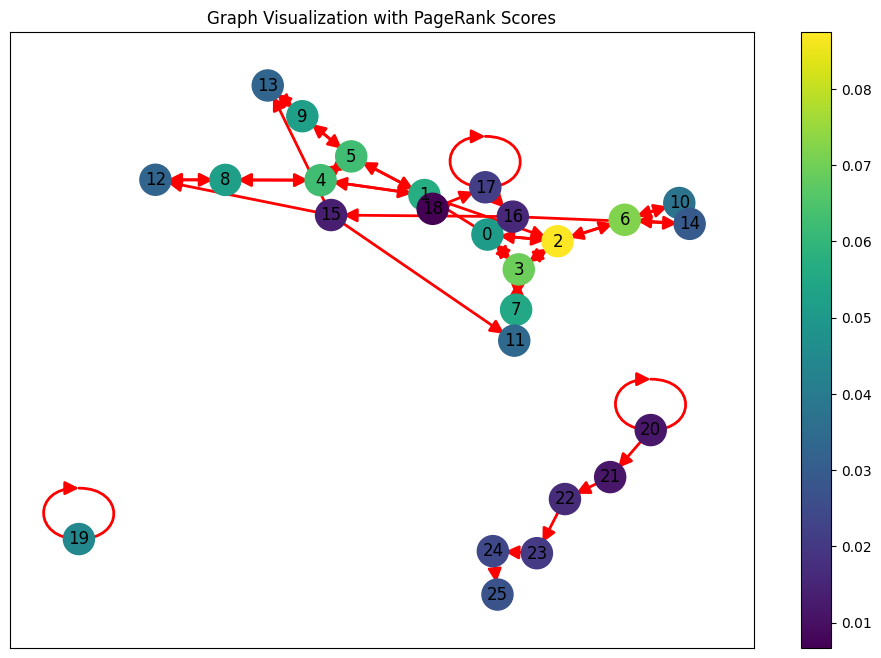

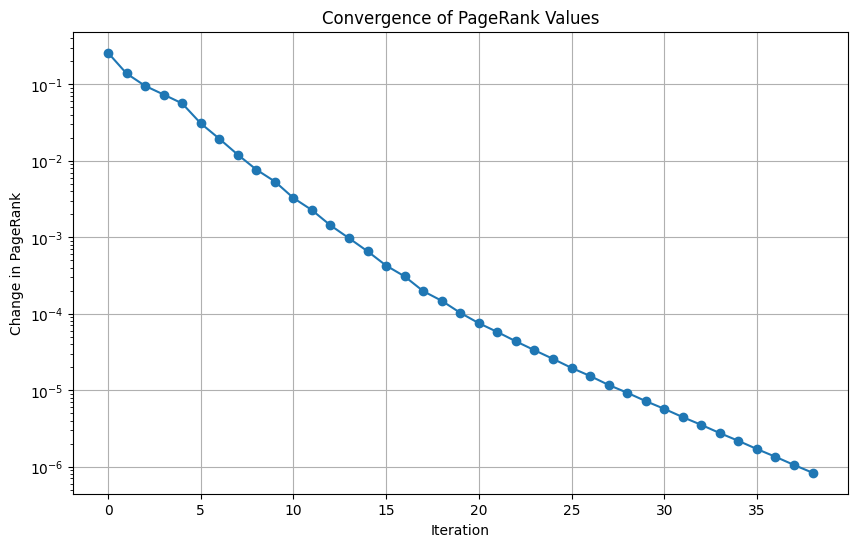

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import networkx as nx

def stothers_williams_multiply(A, B):
    return np.dot(A, B)

def pagerank(adjacency_matrix, alpha=0.85, tol=1e-6, max_iter=100):
    n = adjacency_matrix.shape[0]
    # Handling dangling nodes
    row_sums = adjacency_matrix.sum(axis=1, keepdims=True)
    transition_matrix = adjacency_matrix / row_sums
    transition_matrix[np.isnan(transition_matrix)] = 1 / n  # Handle division by zero

    # Initializing PageRank vector
    pagerank_scores = np.ones(n) / n
    convergence = []

    start_time = time.time()

    for _ in range(max_iter):
        new_pagerank_scores = alpha * stothers_williams_multiply(transition_matrix.T, pagerank_scores) + (1 - alpha) / n
        convergence.append(np.linalg.norm(new_pagerank_scores - pagerank_scores, 1))
        if convergence[-1] < tol:
            pagerank_scores = new_pagerank_scores
            break
        pagerank_scores = new_pagerank_scores

    computation_time = time.time() - start_time

    return pagerank_scores, computation_time, convergence

def sort_page_ranks(page_ranks):
    # Sort page ranks in descending order
    return sorted(enumerate(page_ranks), key=lambda x: x[1], reverse=True)

def visualize_graph(adjacency_matrix, pagerank_scores):
    G = nx.DiGraph(adjacency_matrix)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.viridis,
                                   node_color=pagerank_scores, nodelist=range(len(pagerank_scores)))
    edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='r',
                                   edge_cmap=plt.cm.Blues, width=2)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
    plt.colorbar(nodes)
    plt.title('Graph Visualization with PageRank Scores')
    plt.show()

def plot_convergence(convergence):
    plt.figure(figsize=(10, 6))
    plt.plot(convergence, marker='o')
    plt.title('Convergence of PageRank Values')
    plt.xlabel('Iteration')
    plt.ylabel('Change in PageRank')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Example adjacency matrix
    adjacency_matrix = np.array([
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])

    pr_scores, computation_time, convergence = pagerank(adjacency_matrix)
    print("PageRank Scores:", pr_scores)

    # Sort and display results
    sorted_page_ranks = sort_page_ranks(pr_scores)
    print("Sorted PageRank Scores:")
    for node, rank in sorted_page_ranks:
        print(f"Node {node}: {rank:.4f}")

    print(f"Computation Time: {computation_time:.4f} seconds")

    visualize_graph(adjacency_matrix, pr_scores)
    plot_convergence(convergence)


<ipython-input-6-49a7e63300ba>:8: RuntimeWarning: invalid value encountered in divide
  transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0, keepdims=True)


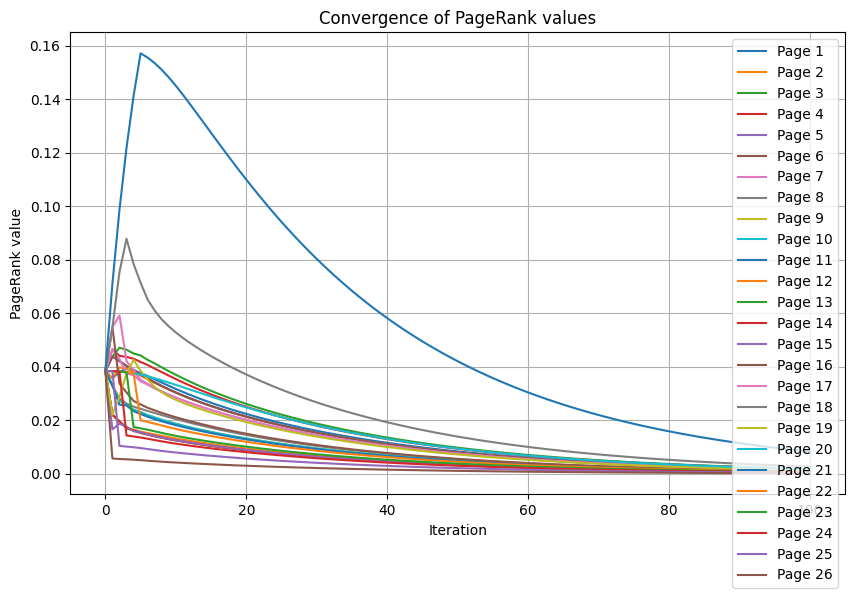

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pagerank_convergence(adjacency_matrix, damping_factor=0.85, max_iter=100, tol=1.0e-6):
    n = adjacency_matrix.shape[0]

    # Transition matrix: Column stochastic matrix
    transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0, keepdims=True)
    transition_matrix = np.nan_to_num(transition_matrix)

    # Handle dead ends: Add a teleportation matrix
    teleportation_matrix = np.ones((n, n)) / n

    # Google matrix
    google_matrix = damping_factor * transition_matrix + (1 - damping_factor) * teleportation_matrix

    # Initial rank vector
    rank_vector = np.ones(n) / n

    # To store PageRank values at each iteration
    pagerank_history = [rank_vector.copy()]

    # Power iteration: Update rank vector until convergence
    for _ in range(max_iter):
        new_rank_vector = google_matrix @ rank_vector
        pagerank_history.append(new_rank_vector.copy())

        if np.linalg.norm(new_rank_vector - rank_vector, 1) < tol:
            break

        rank_vector = new_rank_vector

    return pagerank_history

# Given adjacency matrix
adjacency_matrix = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

# Calculate PageRank convergence
pagerank_history = pagerank_convergence(adjacency_matrix)

# Plot the convergence of PageRank values
pagerank_history = np.array(pagerank_history)
iterations = pagerank_history.shape[0]

plt.figure(figsize=(10, 6))
for i in range(pagerank_history.shape[1]):
    plt.plot(range(iterations), pagerank_history[:, i], label=f'Page {i+1}')
plt.xlabel('Iteration')
plt.ylabel('PageRank value')
plt.title('Convergence of PageRank values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import networkx as nx

def stothers_williams_multiply(A, B):
    return np.dot(A, B)

def pagerank(adjacency_matrix, alpha=0.85, tol=1e-6, max_iter=100):
    n = adjacency_matrix.shape[0]
    # Handling dangling nodes
    row_sums = adjacency_matrix.sum(axis=1, keepdims=True)
    transition_matrix = adjacency_matrix / row_sums
    transition_matrix[np.isnan(transition_matrix)] = 1 / n  # Handle division by zero

    # Initializing PageRank vector
    pagerank_scores = np.ones(n) / n
    convergence_tracking = [pagerank_scores.copy()]  # To track convergence over iterations
    start_time = time.time()

    for iteration in range(max_iter):
        new_pagerank_scores = alpha * stothers_williams_multiply(transition_matrix.T, pagerank_scores) + (1 - alpha) / n
        convergence_tracking.append(new_pagerank_scores.copy())
        if np.linalg.norm(new_pagerank_scores - pagerank_scores, 1) < tol:
            pagerank_scores = new_pagerank_scores
            break
        pagerank_scores = new_pagerank_scores

    computation_time = time.time() - start_time
    num_iterations = iteration + 1
    return pagerank_scores, computation_time, num_iterations, convergence_tracking

def sort_page_ranks(page_ranks):
    return sorted(enumerate(page_ranks), key=lambda x: x[1], reverse=True)

def visualize_graph(adjacency_matrix):
    G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='#FF5733', font_size=10, font_weight='bold')
    plt.show()

def plot_convergence(convergence_tracking):
    plt.figure(figsize=(10, 5))
    for i, scores in enumerate(np.array(convergence_tracking).T):
        plt.plot(scores, label=f'Node {i}')
    plt.xlabel('Iteration')
    plt.ylabel('PageRank Score')
    plt.title('PageRank Convergence Over Iterations')
    plt.legend()
    plt.show()

# Example usage:
if __name__ == "__main__":
    adjacency_matrix = np.array([
                   [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])

    pr_scores, computation_time, num_iterations, convergence_tracking = pagerank(adjacency_matrix)
    print(f"PageRank Scores: {pr_scores}")
    print(f"Computation Time: {computation_time:.4f} seconds")
    print(f"Number of Iterations: {num_iterations}")

PageRank Scores: [0.05108789 0.05657572 0.08747202 0.06932948 0.06254111 0.06254111
 0.0721487  0.05508254 0.05207163 0.05207163 0.03732401 0.03385693
 0.03257737 0.03257737 0.02922526 0.01336257 0.0157688  0.0214305
 0.00666083 0.04440555 0.01158406 0.01158406 0.01650728 0.02069202
 0.02424905 0.02727253]
Computation Time: 0.0005 seconds
Number of Iterations: 39


<ipython-input-27-bbd3ee16fb5d>:13: RuntimeWarning: invalid value encountered in divide
  transition_matrix = adjacency_matrix / row_sums


In [ ]:
    sorted_page_ranks = sort_page_ranks(pr_scores)
    print("Sorted PageRank Scores:")
    for node, rank in sorted_page_ranks:
        print(f"Node {node}: {rank:.4f}")

Sorted PageRank Scores:
Node 2: 0.0875
Node 6: 0.0721
Node 3: 0.0693
Node 4: 0.0625
Node 5: 0.0625
Node 1: 0.0566
Node 7: 0.0551
Node 8: 0.0521
Node 9: 0.0521
Node 0: 0.0511
Node 19: 0.0444
Node 10: 0.0373
Node 11: 0.0339
Node 12: 0.0326
Node 13: 0.0326
Node 14: 0.0292
Node 25: 0.0273
Node 24: 0.0242
Node 17: 0.0214
Node 23: 0.0207
Node 22: 0.0165
Node 16: 0.0158
Node 15: 0.0134
Node 20: 0.0116
Node 21: 0.0116
Node 18: 0.0067


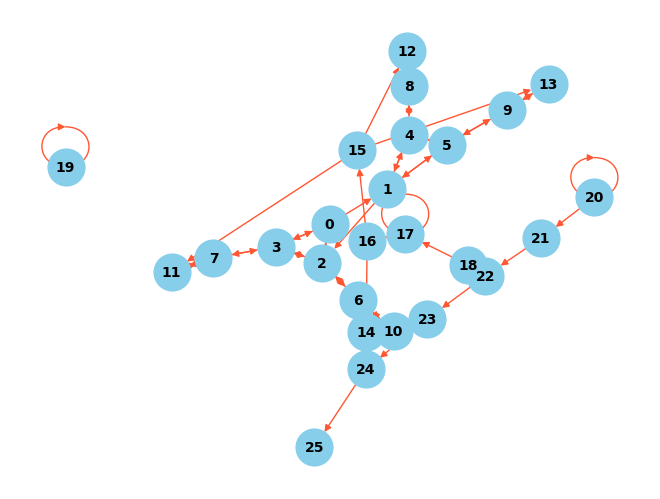

In [ ]:
    visualize_graph(adjacency_matrix)


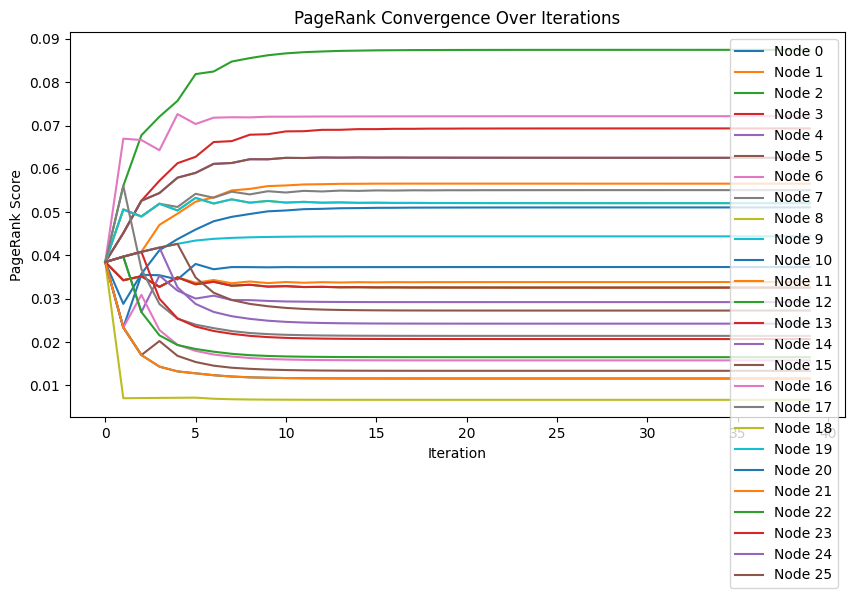

In [ ]:
    plot_convergence(convergence_tracking)

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

# Load the dataset
edges = []
with open('web-Google.txt', 'r') as file:
    for line in file:
        if line.startswith('#'):
            continue
        src, dst = line.strip().split()
        edges.append((int(src), int(dst)))

# Create a directed graph using NetworkX
G = nx.DiGraph()
G.add_edges_from(edges)

# Ensure all nodes have at least one outgoing link (for simplification)
for node in G.nodes():
    if G.out_degree(node) == 0:
        G.add_edge(node, node)

# Print basic info about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 260815
Number of edges: 1103613


In [ ]:
# Calculate PageRank
pagerank = nx.pagerank(G, alpha=0.85)

# Convert the result to a DataFrame for better visualization
pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['Node', 'PageRank'])
pagerank_df = pagerank_df.sort_values(by='PageRank', ascending=False)

# Display the dataframe using pandas
pagerank_df.head()

,Node,PageRank
8055,885605,0.000601
1301,846221,0.000401
3612,557124,0.000292
115,597621,0.000275
2138,41909,0.000240


In [ ]:
top_10_pagerank = pagerank_df.head(10)
print(top_10_pagerank)

         Node  PageRank
8055   885605  0.000601
1301   846221  0.000401
3612   557124  0.000292
115    597621  0.000275
2138    41909  0.000240
1181   504140  0.000225
13083  751384  0.000214
3167   425770  0.000212
1611   558791  0.000211
3150    32163  0.000210


In [ ]:
# Numerical Analysis: Summary Statistics
summary_stats = pagerank_df.describe()
print(summary_stats)

                Node      PageRank
count  260815.000000  2.608150e+05
mean   447994.512022  3.834135e-06
std    278526.472099  3.701157e-06
min         0.000000  5.751203e-07
25%    203129.500000  2.761265e-06
50%    451152.000000  4.132710e-06
75%    692988.000000  4.421663e-06
max    916426.000000  6.005000e-04


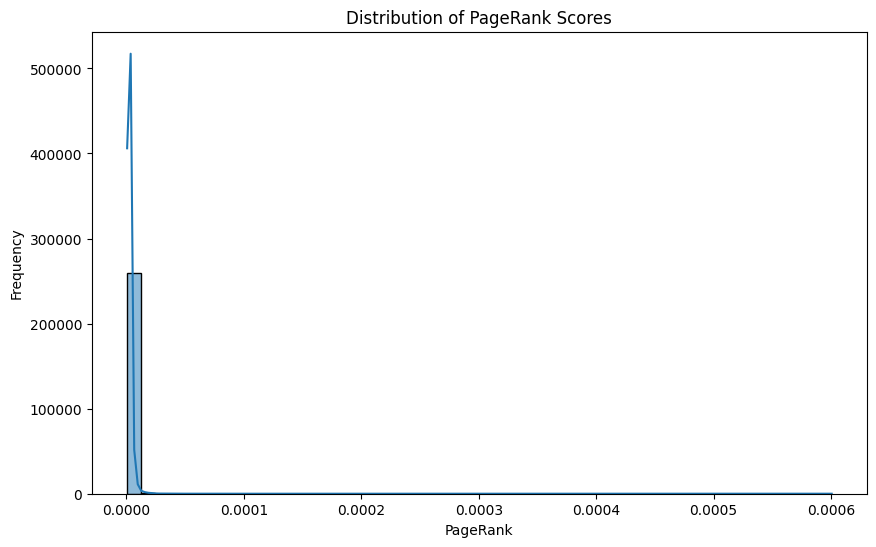

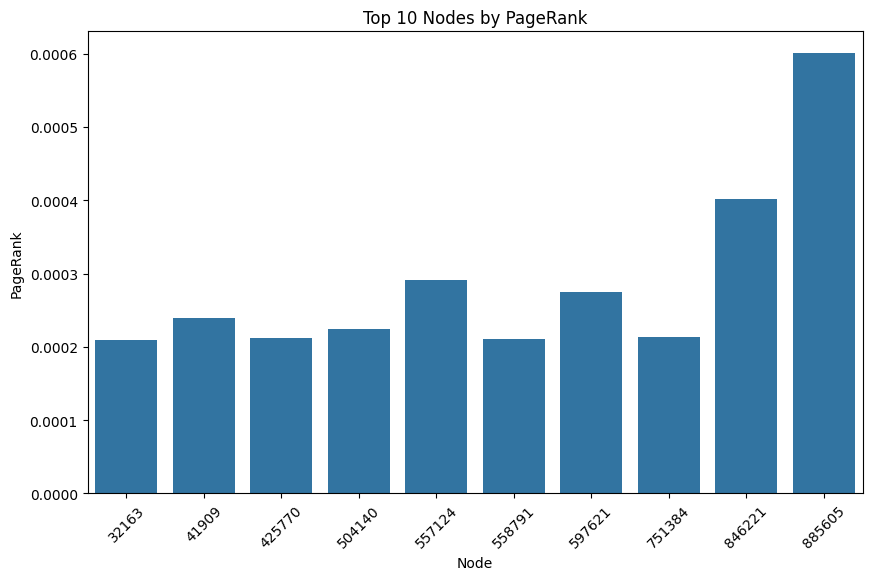

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the graph structure
# Graphical Analysis

# 1. Distribution of PageRank scores
plt.figure(figsize=(10, 6))
sns.histplot(pagerank_df['PageRank'], bins=50, kde=True)
plt.title('Distribution of PageRank Scores')
plt.xlabel('PageRank')
plt.ylabel('Frequency')
plt.show()

# 2. Top 10 nodes by PageRank
plt.figure(figsize=(10, 6))
sns.barplot(x='Node', y='PageRank', data=top_10_pagerank)
plt.title('Top 10 Nodes by PageRank')
plt.xlabel('Node')
plt.ylabel('PageRank')
plt.xticks(rotation=45)
plt.show()

# 3. Visualization of the graph structure
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title('Graph Structure Visualization')
plt.show()

# 4. Comparison with other centrality measures

# In-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)
in_degree_df = pd.DataFrame(list(in_degree_centrality.items()), columns=['Node', 'InDegree'])
in_degree_df = in_degree_df.sort_values(by='InDegree', ascending=False)

# Out-degree centrality
out_degree_centrality = nx.out_degree_centrality(G)
out_degree_df = pd.DataFrame(list(out_degree_centrality.items()), columns=['Node', 'OutDegree'])
out_degree_df = out_degree_df.sort_values(by='OutDegree', ascending=False)

# Merging all centrality measures into one dataframe
centrality_df = pagerank_df.merge(in_degree_df, on='Node').merge(out_degree_df, on='Node')

# 5. Correlation analysis between PageRank and other centrality measures
correlation_matrix = centrality_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Centrality Measures')
plt.show()

# Scatter plots for visual comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(x='InDegree', y='PageRank', data=centrality_df)
plt.title('PageRank vs In-Degree Centrality')
plt.xlabel('In-Degree Centrality')
plt.ylabel('PageRank')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='OutDegree', y='PageRank', data=centrality_df)
plt.title('PageRank vs Out-Degree Centrality')
plt.xlabel('Out-Degree Centrality')
plt.ylabel('PageRank')
plt.show()